In [5]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import spacy
from transformers import pipeline, AutoTokenizer, AutoModel
from spacy.matcher import PhraseMatcher
from spacy.util import filter_spans
from collections import Counter
from spellchecker import SpellChecker
from IPython.display import display, HTML
import enchant
import ast

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

print('utils.py loaded')

utils.py loaded


# data preprocess for EDA


In [6]:
transcripts_df = pd.read_csv(
    'data/transcripts_tokenized.csv',
    converters={
        'players': ast.literal_eval,
        'events': ast.literal_eval,
        'tokenized_event_name': ast.literal_eval,
        'tokenized_text': ast.literal_eval,
        'actions_in_text': ast.literal_eval
    }
)
ACTIONS = list(set(pd.read_csv("data/actions.csv")["parameter"]))

# plot sanity check on data


In [7]:
# 1. Count rows
print("Number of rows:", len(transcripts_df))

# 2. Nulls per column
print("\nNulls per column:\n", transcripts_df.isnull().sum())

# 3. Unique "Text" values out of #rows
n_unique_text = transcripts_df['Text'].nunique()
print(f"\nUnique 'Text' values: {n_unique_text} / {len(transcripts_df)}")

n_unique_text_lemmatized = transcripts_df['tokenized_text'].apply(tuple).nunique()
print(f"\nUnique 'Text' lemmatized values: {n_unique_text_lemmatized} / {len(transcripts_df)}")


# 5. % of [None] in events
pct_none_list = transcripts_df['events'].apply(lambda x: isinstance(x, list) and x == [None]).mean() * 100
print(f"\nUndetected events (% of [None]): {pct_none_list:.2f}%")

# 6. Flatten events and count events
from collections import Counter

# 6. Flatten events and count events
events = []
for row in transcripts_df['events']:
    items = row if isinstance(row, list) else []
    events.extend([a for a in items if a is not None])
events_counts = Counter(events)
print("\Events counts (top 20):", events_counts.most_common(20))

# 7. Flatten players and count players
players = []
for row in transcripts_df['players']:
    items = row if isinstance(row, list) else []
    players.extend([p for p in items if p is not None])
player_counts = Counter(players)
print("\nPlayer counts (top 20):", player_counts.most_common(20))

Number of rows: 1105

Nulls per column:
 sample_id               0
EventNameCleaned        0
Text                    0
Label                   0
actions_in_text         0
tokenized_text          0
tokenized_event_name    0
players                 0
events                  0
dtype: int64

Unique 'Text' values: 1021 / 1105

Unique 'Text' lemmatized values: 993 / 1105

Undetected events (% of [None]): 3.98%
\Events counts (top 20): [('Missed Shot', 404), ('2-pointer', 278), ('Rebound', 239), ('Assist', 149), ('Turnover', 81), ('3-pointer', 77), ('Foul', 72), ('Dunk', 58), ('Steal', 47), ('Block', 24), ('Jump Ball', 13), ('2-pts Made', 12), ('FT-Made', 8), ('3-pts Made', 6), ('Quarter End', 3), ('FT-Missed', 2)]

Player counts (top 20): [('Luka Doncic', 18), ('James Harden', 17), ('Julius Randle', 17), ('Jayson Tatum', 17), ('Giannis Antetokounmpo', 17), ('Trae Young', 17), ('Joel Embiid', 16), ('Ben Simmons', 16), ('Nikola Jokic', 16), ('CJ McCollum', 15), ('Kyle Lowry', 14), ('Clint Cape

Set of all typos in 'Text' (ordered by count desc): ['fadeaway', 'Oop', 'Jokic', 'Lowry', 'oop', 'wo', 'na', 'Lillard', 'gon', 'Millsap', 'Aldridge', 'Nurkic', 'Westbrook', 'Drummond', 'Gobert', 'Giannis', 'Rozier', 'Horford', 'Rubio', 'midrange', 'Kemba', 'Whiteside', 'Brogdon', 'LeBron', 'Brunson', 'Cauley', 'Dedmon', 'Embiid', 'McCollum', 'Vucevic', 'Lakers', 'Bogdanovich', 'Doncic', 'Tobias', 'PJ', 'Lamarcus', 'CJ', 'Wiseman', 'Trae', 'DeAngelo', 'Fournier', 'Gallinari', 'Randle', 'Zeller', 'Ibaka', 'Aminu', 'Lonzo', 'Draymond', 'Villin', 'jokisch', 'Knicks', 'DeRozan', 'Belinelli', 'Bam', 'Brockton', 'Luka', 'Harkless', 'Peyton', 'KD', 'TJ', 'Teague', 'Hardaway', 'Porzingis', 'Looney', 'RJ', 'joellen', 'DeAndre', 'Klay', 'Zach', 'handoff', 'Satiran', 'Crowder', 'Hield', 'JJ', 'Redick', 'Jaylen', 'Baynes', 'Delon', 'dogic', 'fibrosing', 'Theis', 'Danilo', 'Nixa', 'Adebayo', 'Putun', 'Bazemore', 'Millsaps', 'NYT', 'Taj', 'Depoorter', 'Geron', 'Bledsoe', 'Kowhai', 'comms', 'Domasin',

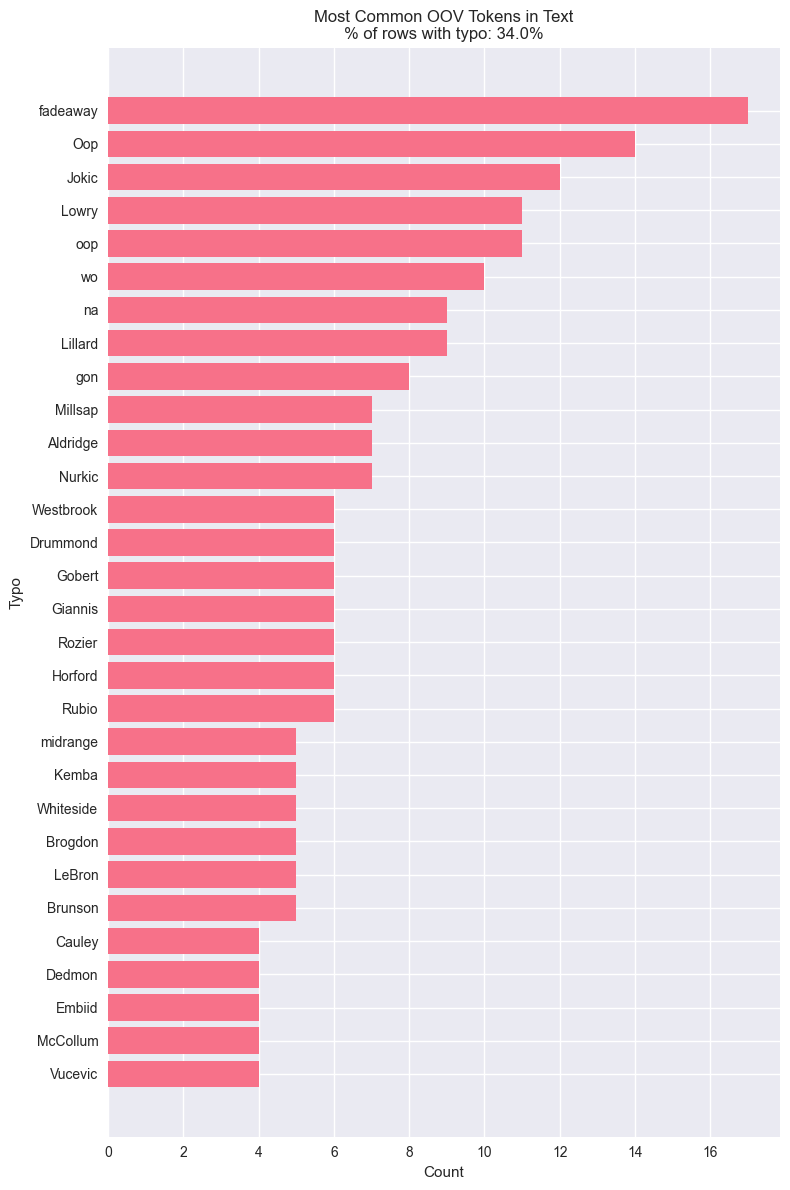

Set of all typos in 'Text' (ordered by count desc): ['fadeaway', 'oop', 'wo', 'na', 'gon', 'Oop', 'midrange', 'jokisch', 'joellen', 'handoff', 'dogic', 'fibrosing', 'Millsaps', 'Depoorter', 'Geron', 'comms', 'Posterize', 'RHJ', 'lazatin', 'Rescreening', 'cragan', 'undrafted', 'fadeaways', 'matchups', 'backcourt', 'Ombre', 'valentinas', 'embid', 'leaners', 'stepbacks', 'javel', 'clays', 'Schreuder', 'Olynyk', 'Satiran', 'autobio', 'pitchout', 'Lonzo', 'Deleter', 'kalo', 'dolla', 'Dreidel', 'ai', 'Gon', 'backdoors', 'Fultz', 'Olinick', 'kupas', 'Baynes', 'Tyreek', 'kupo', 'zubat', 'Oladipo', 'annaleise', 'panga', 'alot', 'instaflex']


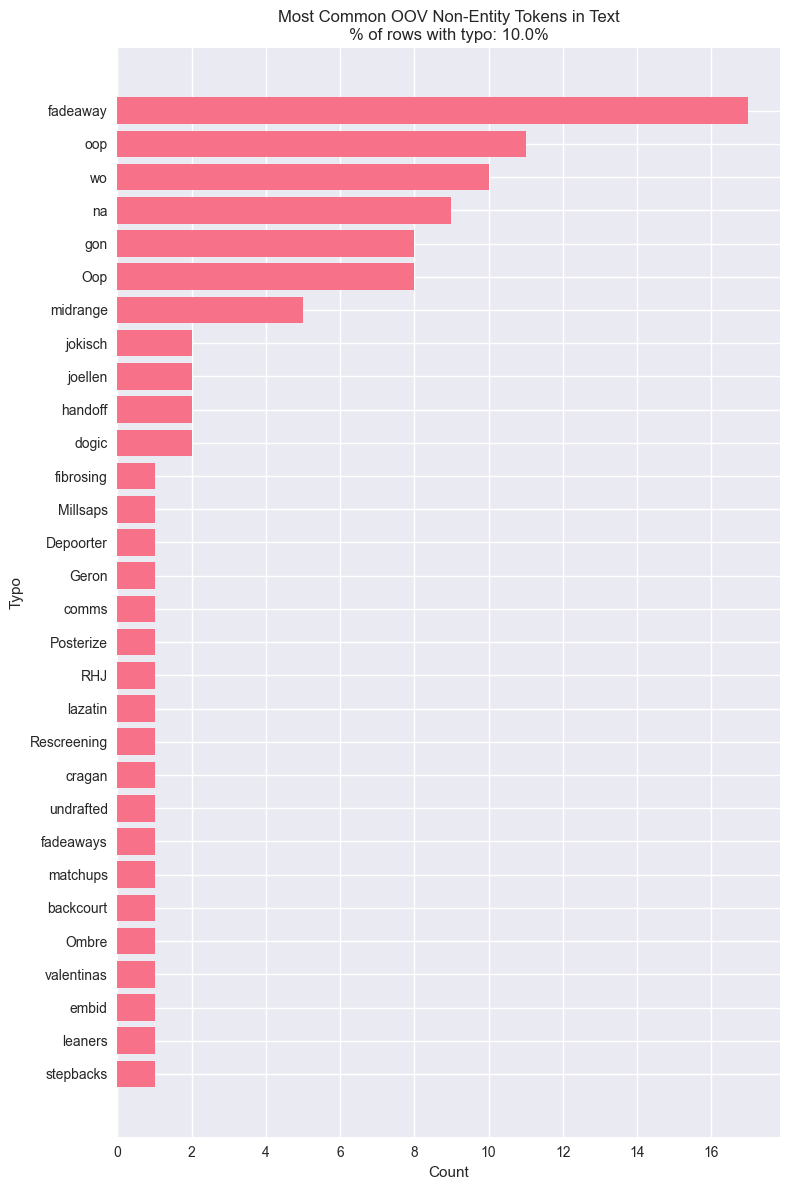

Set of all typos in 'Text' (ordered by count desc): ['fadeaway', 'oop', 'wo', 'na', 'gon', 'midrange', 'jokisch', 'joellen', 'handoff', 'dogic', 'fibrosing', 'Oop', 'Millsaps', 'comms', 'Posterize', 'lazatin', 'Rescreening', 'cragan', 'undrafted', 'fadeaways', 'matchups', 'backcourt', 'valentinas', 'embid', 'leaners', 'stepbacks', 'javel', 'clays', 'Schreuder', 'Olynyk', 'pitchout', 'Deleter', 'kalo', 'dolla', 'ai', 'Gon', 'backdoors', 'Baynes', 'zubat', 'annaleise', 'panga', 'alot', 'instaflex']


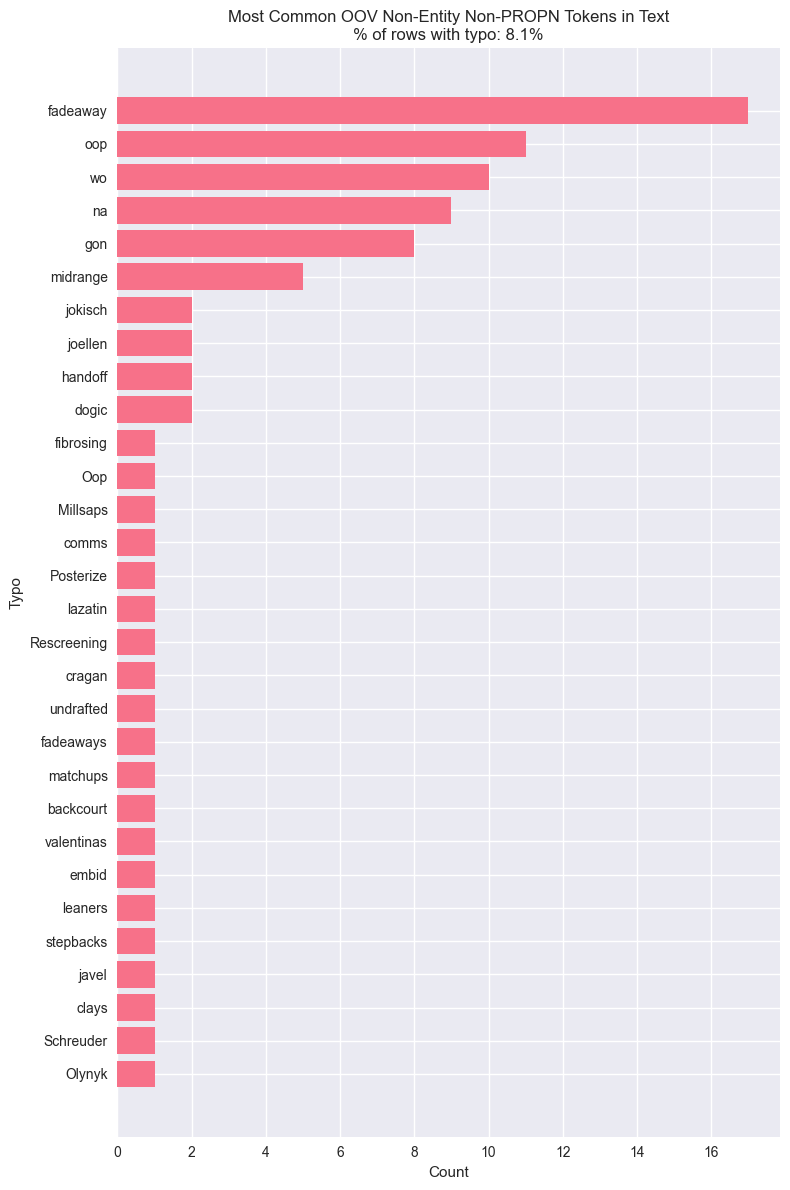

Set of all typos in 'EventNameCleaned' (ordered by count desc): ['Nikola', 'pts', 'Luka', 'Doncic', 'Randle', 'Giannis', 'Antetokounmpo', 'Trae', 'Embiid', 'Jokic', 'CJ', 'McCollum', 'Lowry', 'Capela', 'Jusuf', 'Nurkic', 'Danilo', 'Gallinari', 'Drummond', 'Lillard', 'Gobert', 'Horford', 'Khris', 'Jrue', 'Vucevic', 'Bogdanovic', 'LeBron', 'Valanciunas', 'LaMarcus', 'Aldridge', 'Gasol', 'Jaylen', 'Rubio', 'Beal', 'Zach', 'Ibaka', 'Cauley', 'Satoransky', 'Tobias', 'Millsap', 'LaVine', 'Kemba', 'Bojan', 'Hassan', 'Whiteside', 'Ingles', 'Klay', 'Fournier', 'Bledsoe', 'DeMar', 'DeRozan', 'Bryn', 'Huerter', 'Brogdon', 'Rozier', 'JaVale', 'Westbrook', 'Draymond', 'Devonte', 'Dragan', 'Mikal', 'Marcin', 'Gortat', 'Kentavious', 'Kristaps', 'Porzingis', 'Payton', 'Jerami', 'Hardaway', 'DeAndre', 'Cedi', 'Siakam', 'Jalen', 'Kawhi', 'Ivica', 'Zubac', 'Caris', 'LeVert', 'Richaun', 'DeMarcus', 'Shai', 'Gilgeous', 'PJ', 'Dedmon', 'Taurean', 'Bazemore', 'VanVleet', 'OG', 'Anunoby', 'Brunson', 'Zeller',

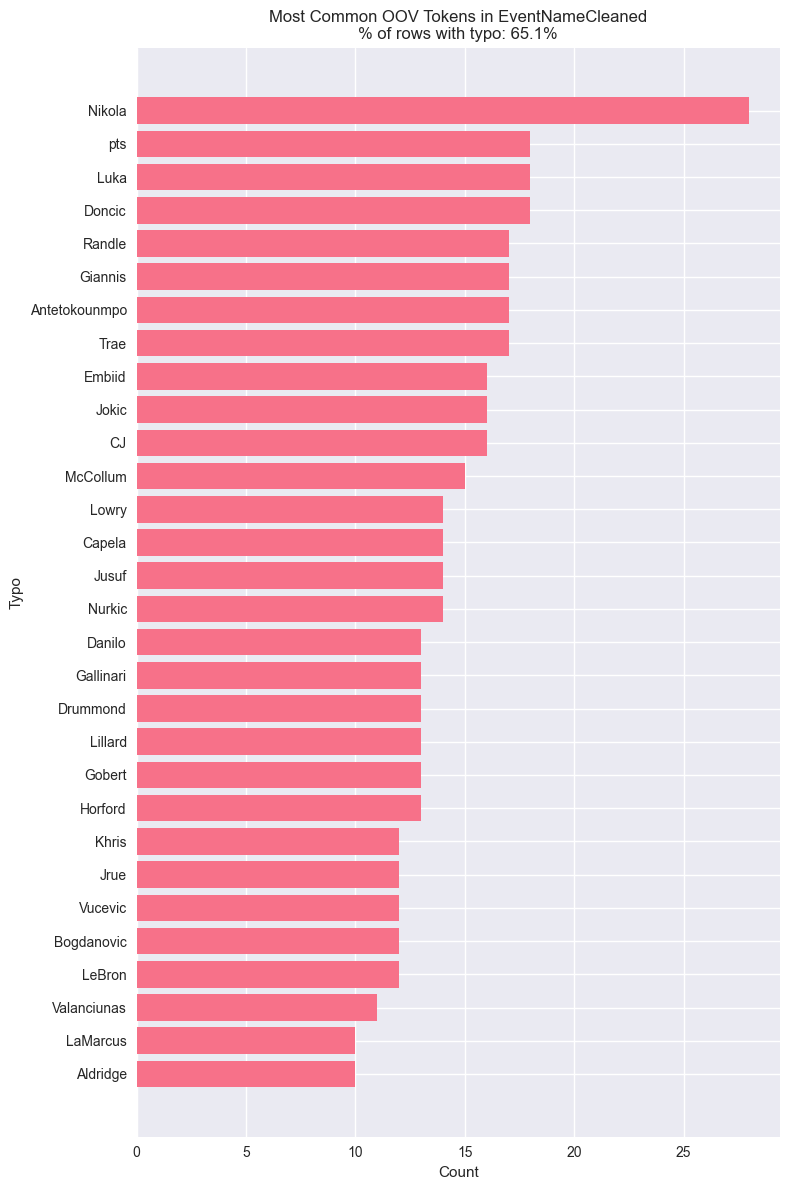

Set of all typos in 'EventNameCleaned' (ordered by count desc): ['Zizic', 'Guerschon', 'Yabusele']


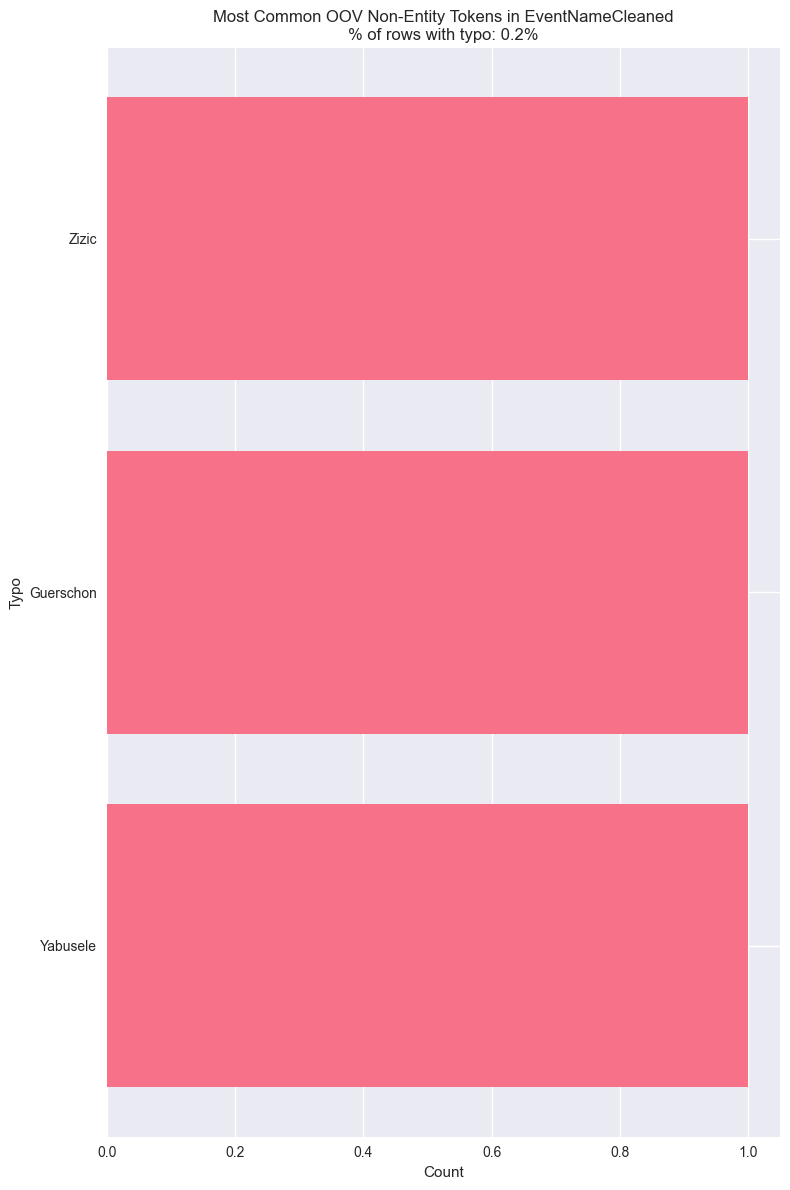

Set of all typos in 'EventNameCleaned' (ordered by count desc): []


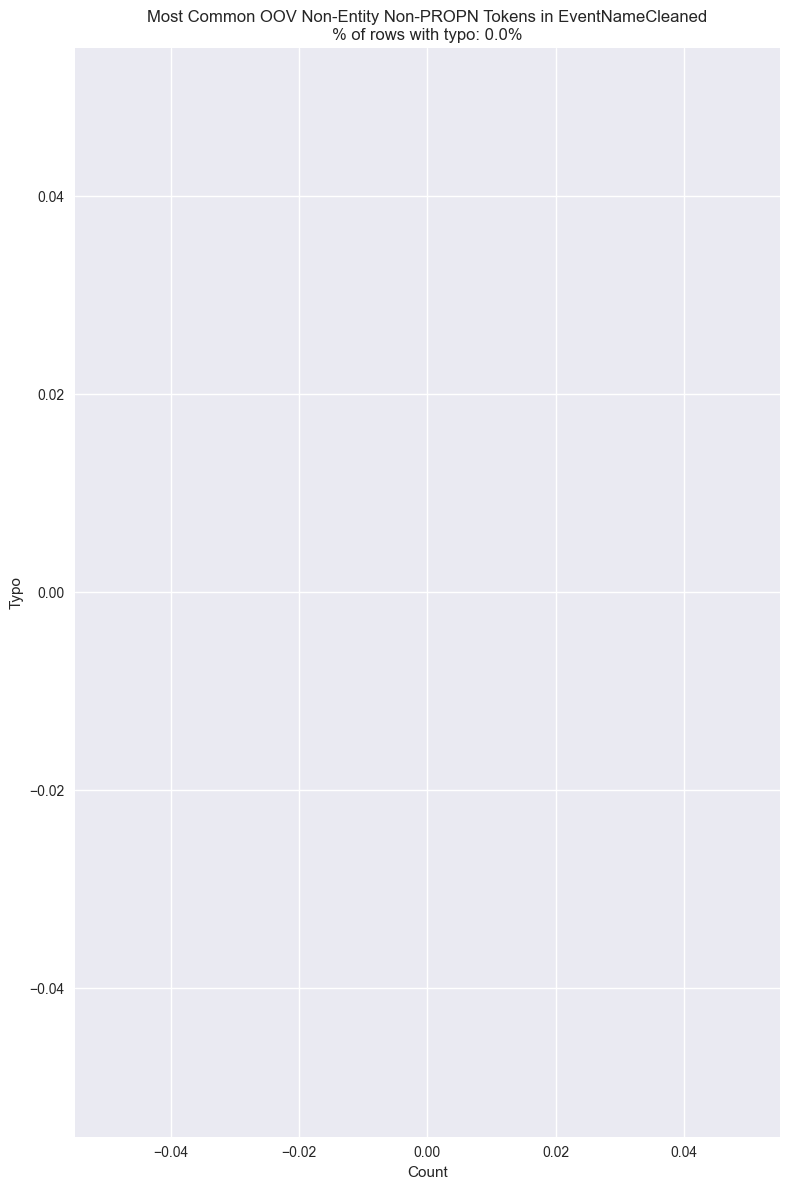

In [8]:
nlp, spell = spacy.load("en_core_web_lg"), SpellChecker()
d = enchant.Dict("en_US")

def detect_oov_and_typos(text):    
    doc = nlp(text)

    all_words = [token for token in doc if token.is_alpha]
    
    oov_tokens = [token for token in all_words if not d.check(token.text)]
    
    oov_NER_tokens = [token for token in oov_tokens if not token.ent_type_]

    oov_NER_PROPN_text = [token.text for token in oov_NER_tokens if token.pos_ != "PROPN"]
    return [token.text for token in oov_tokens], [token.text for token in oov_NER_tokens], oov_NER_PROPN_text

def typo_analysis(df, col, which=0, most_common_amount=30, plot_title=None):
    # which: 0 = oov_tokens, 1 = oov_NER_tokens, 2 = oov_NER_PROPN_text
    typos_col = f"{col}_typos_{which}"
    df[typos_col] = df[col].apply(lambda x: detect_oov_and_typos(x)[which])

    typo_counts = Counter(t for row in df[typos_col] for t in row)
    common_typos = typo_counts.most_common(most_common_amount)

    pct_rows_with_typo = (df[typos_col].apply(lambda x: len(x) > 0).mean()) * 100

    print(f"Set of all typos in '{col}' (ordered by count desc):", [t[0] for t in typo_counts.most_common(len(typo_counts))])

    plt.figure(figsize=(8, 12))
    plt.barh([t[0] for t in reversed(common_typos)], [t[1] for t in reversed(common_typos)])
    title_main = plot_title or f"Most Common Typos (OOV) in {col}"
    plt.title(f"{title_main}\n% of rows with typo: {pct_rows_with_typo:.1f}%")
    plt.xlabel("Count")
    plt.ylabel("Typo")
    plt.tight_layout()
    plt.show()

# Run typo analysis on 'Text' for all 3 lists
oov_df = transcripts_df.copy()

typo_analysis(oov_df, "Text", which=0, most_common_amount=30, plot_title="Most Common OOV Tokens in Text")
typo_analysis(oov_df, "Text", which=1, most_common_amount=30, plot_title="Most Common OOV Non-Entity Tokens in Text")
typo_analysis(oov_df, "Text", which=2, most_common_amount=30, plot_title="Most Common OOV Non-Entity Non-PROPN Tokens in Text")

# Run typo analysis on 'EventNameCleaned' for all 3 lists
typo_analysis(oov_df, "EventNameCleaned", which=0, most_common_amount=30, plot_title="Most Common OOV Tokens in EventNameCleaned")
typo_analysis(oov_df, "EventNameCleaned", which=1, most_common_amount=30, plot_title="Most Common OOV Non-Entity Tokens in EventNameCleaned")
typo_analysis(oov_df, "EventNameCleaned", which=2, most_common_amount=30, plot_title="Most Common OOV Non-Entity Non-PROPN Tokens in EventNameCleaned")

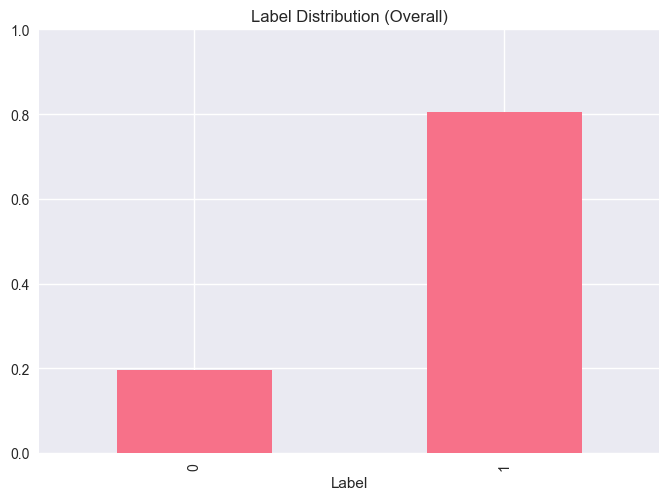

1 word count peak: 6.6
0 word count peak: 9.0


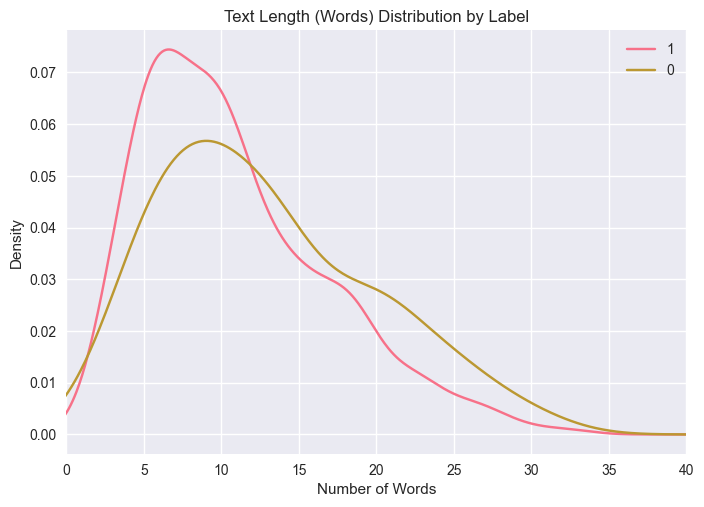

1 tokenized token count peak: 3.5
0 tokenized token count peak: 3.9


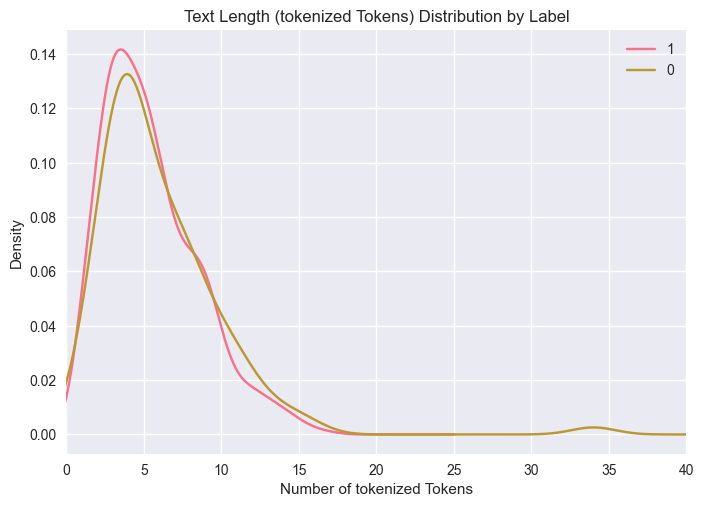

In [9]:
transcripts_df['Label'].value_counts(normalize=True).plot.bar(title='Label Distribution (Overall)', ylim=(0,1))
plt.gca().invert_xaxis()
plt.show()

# Plot 1: Distribution of "Text" length (number of words) per label, x range 0-40
for label in transcripts_df['Label'].unique():
    lengths = transcripts_df[transcripts_df['Label'] == label]['Text'].str.split().apply(len)
    ax = lengths.plot(kind='kde', label=label, xlim=(0, 40))
    kde = ax.get_lines()[-1]
    x, y = kde.get_data()
    # Trim x and y to x <= 40
    mask = x <= 40
    x, y = x[mask], y[mask]
    peak_idx = y.argmax()
    print(f"{label} word count peak: {x[peak_idx]:.1f}")
plt.title('Text Length (Words) Distribution by Label')
plt.xlabel('Number of Words')
plt.xlim(0, 40)
plt.legend()
plt.show()

# Plot 2: Distribution of lemmatized token length per label, x range 0-40
for label in transcripts_df['Label'].unique():
    lengths = transcripts_df[transcripts_df['Label'] == label]['tokenized_text'].apply(len)
    ax = lengths.plot(kind='kde', label=label, xlim=(0, 40))
    kde = ax.get_lines()[-1]
    x, y = kde.get_data()
    # Trim x and y to x <= 40
    mask = x <= 40
    x, y = x[mask], y[mask]
    peak_idx = y.argmax()
    print(f"{label} tokenized token count peak: {x[peak_idx]:.1f}")
plt.title('Text Length (tokenized Tokens) Distribution by Label')
plt.xlabel('Number of tokenized Tokens')
plt.xlim(0, 40)
plt.legend()
plt.show()

In [27]:
transcripts_df[['tokenized_event_name']]

,tokenized_event_name
0,"['miss', 'shot', 'darren', 'collison', 'rebound', 'joel', 'embiid']"
1,"['3_pointer', 'pj', 'tucker', 'assist', 'eric', 'gordon']"
2,"['dunk', 'aaron', 'gordon', 'assist', 'evan', 'fournier']"
3,"['miss', 'shot', 'gordon', 'hayward']"
4,"['rebound', 'eric', 'bledsoe']"
...,...
1100,"['miss', 'shot', 'john', 'collins']"
1101,"['turnover', 'tomas', 'satoransky']"
1102,"['replay', 'auto']"
1103,"['2_pointer', 'otto', 'porter', 'jr.']"


In [22]:

def plot_label_distribution_for_ngrams(col_name):
    max_k_to_plot = 30
    def get_ngrams(tokens, n):
        return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    for n, label in zip([1, 2], ['Unigram', 'Bigram']):
        ngram_col = f"{col_name}_{label.lower()}"
        ngram_series = transcripts_df[col_name].apply(lambda x: get_ngrams(x, n))
        top_ngrams = set()
        for l in transcripts_df['Label'].unique():
            top_ngrams |= set([w for w, _ in Counter(ngram_series[transcripts_df['Label'] == l].explode()).most_common(max_k_to_plot)])
        plot_df = transcripts_df.copy()
        plot_df[ngram_col] = ngram_series
        plot_df = plot_df.explode(ngram_col)
        plot_df = plot_df[plot_df[ngram_col].isin(top_ngrams)]
        plt.figure(figsize=(8, 12), dpi=100)
        sns.countplot(
            y=plot_df[ngram_col],
            hue=plot_df['Label'],
            order=plot_df[ngram_col].value_counts().index
        )
        plt.title(f'Label Distribution in Top {label}s of {col_name}', fontsize=16)
        plt.xlabel('Count')
        plt.ylabel(label)
        plt.tight_layout()
        plt.show()

### Events Analysis

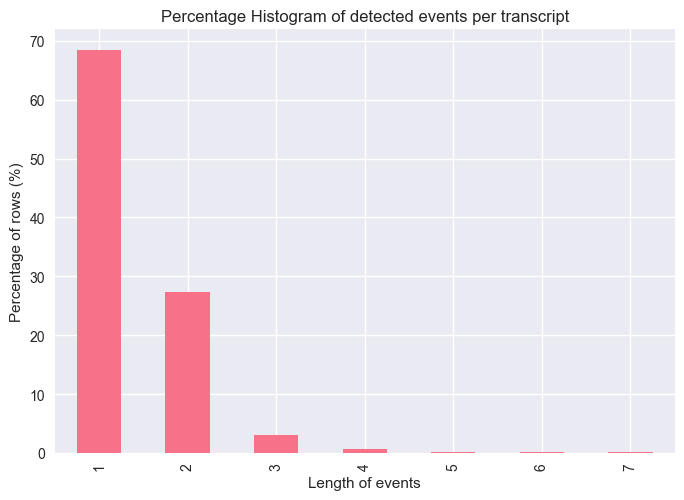

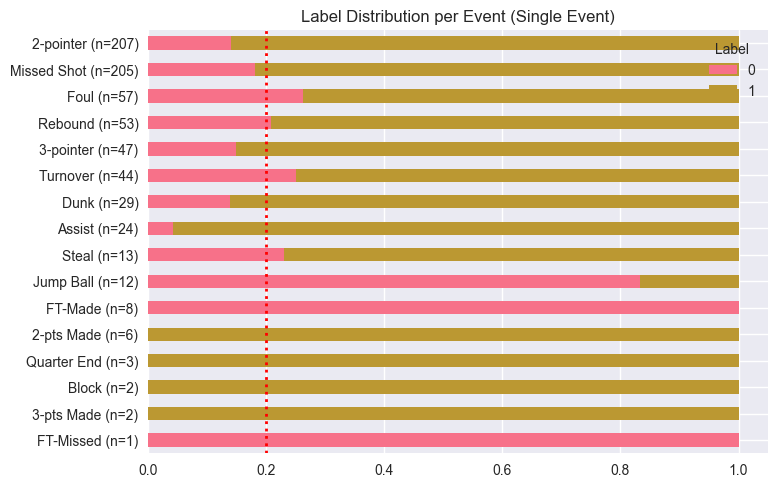

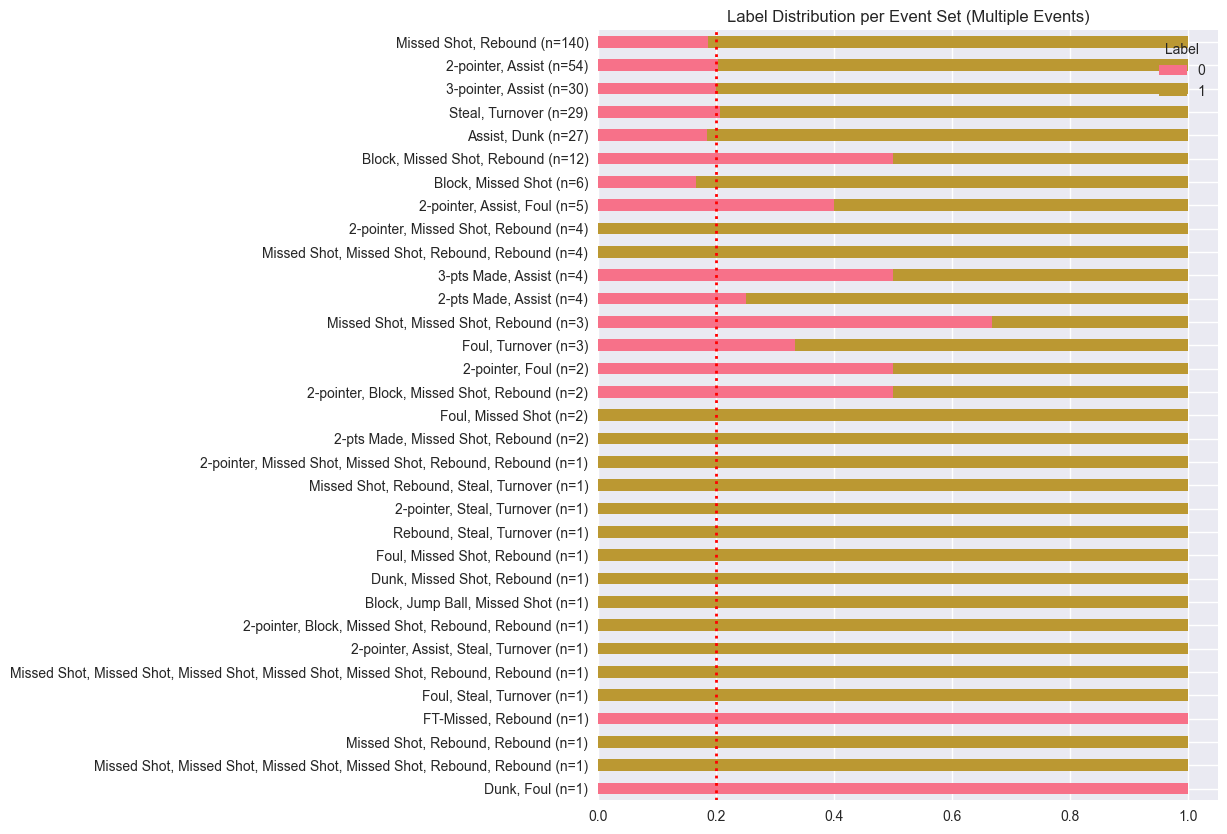

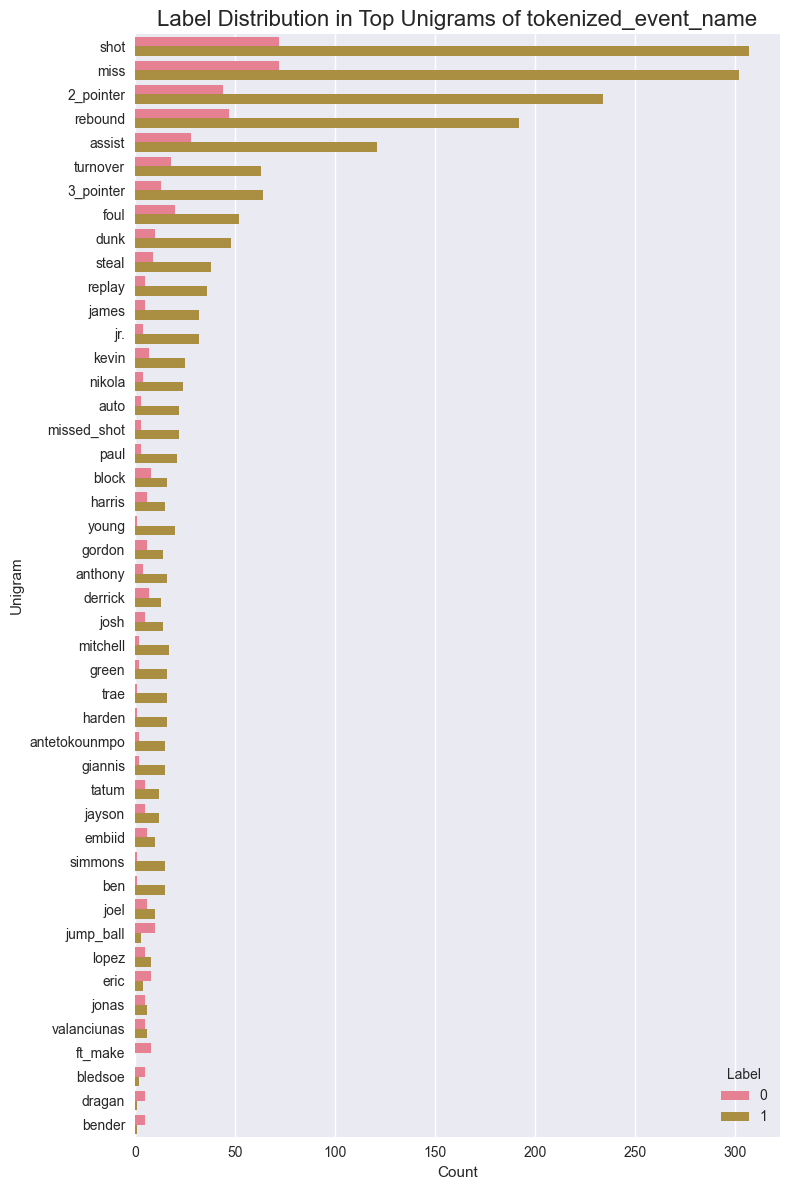

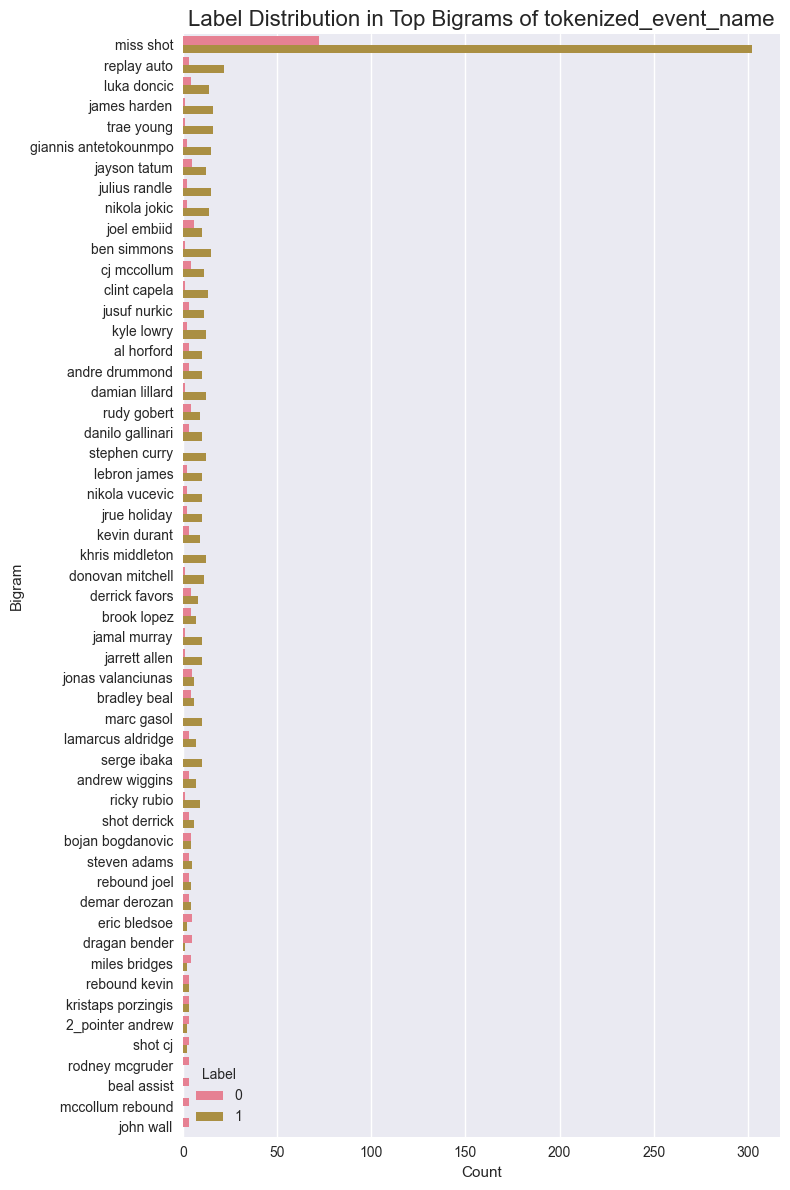

In [30]:

# 4. Histogram: percentage of rows by len(events)
event_lens = transcripts_df['events'].apply(lambda x: len(x) if isinstance(x, list) else 0)
percentages = event_lens.value_counts(normalize=True).sort_index() * 100
percentages.plot(kind='bar')
plt.xlabel('Length of events')
plt.ylabel('Percentage of rows (%)')
plt.title('Percentage Histogram of detected events per transcript')
plt.show()


# 1.2 Label distribution per event (single event rows)
mask_single = transcripts_df['events'].apply(lambda x: isinstance(x, list) and len(x) == 1)
single_events = transcripts_df[mask_single].copy()
single_events['event'] = single_events['events'].str[0]
counts = single_events['event'].value_counts()
labels = single_events.groupby('event')['Label'].value_counts(normalize=True).unstack().loc[counts.index]
labels.index = [f"{e} (n={counts[e]})" for e in labels.index]
ax = labels.plot.barh(stacked=True, title='Label Distribution per Event (Single Event)')
ax.axvline(0.2, color='red', linestyle='dotted', linewidth=2)
ax.invert_yaxis()
ax.legend(title='Label')
plt.show()


# 1.3 Label distribution per event set (multiple event rows)
mask_multi = transcripts_df['events'].apply(lambda x: isinstance(x, list) and len(x) > 1)
multi_events = transcripts_df[mask_multi].copy()
multi_events['event_set'] = multi_events['events'].apply(lambda x: ', '.join(sorted(x)))
set_counts = multi_events['event_set'].value_counts()
set_labels = multi_events.groupby('event_set')['Label'].value_counts(normalize=True).unstack().loc[set_counts.index]
set_labels.index = [f"{e} (n={set_counts[e]})" for e in set_labels.index]
fig, ax2 = plt.subplots(figsize=(8, 10))  # Increased height from default
set_labels.plot.barh(stacked=True, title='Label Distribution per Event Set (Multiple Events)', ax=ax2)
ax2.axvline(0.2, color='red', linestyle='dotted', linewidth=2)
ax2.invert_yaxis()
ax2.legend(title='Label')
plt.show()


plot_label_distribution_for_ngrams('tokenized_event_name')

### Actions Analysis

applied basic lemmatization using spacy and searched the term in text

In [33]:
transcripts_df[transcripts_df['actions_in_text'].apply(lambda x: isinstance(x, list) and len(x) > 1)]

,sample_id,EventNameCleaned,Text,Label,actions_in_text,tokenized_text,tokenized_event_name,players,events
55,56,2-pointer by Khris Middleton,Middleton to fake the floater?,1,"[floater, fake]","[middleton, fake, floater]","[2_pointer, khris, middleton]",[Khris Middleton],[2-pointer]
114,115,"Missed Shot by Lonzo Ball, Rebound by Jalen Brunson","They're going to blitz, which means double team on the pick and roll.",0,"[double_team, pick_and_roll]","[blitz, mean, double_team, pick_and_roll]","[miss, shot, lonzo, ball, rebound, jalen, brunson]","[Lonzo Ball, Jalen Brunson]","[Missed Shot, Rebound]"
173,174,"Missed Shot by Collin Sexton, Rebound by Thomas Bryant",Shot Clock down to Claude will post up in a fadeaway here for Sexton.,1,"[fadeaway, post_up]","[shot, clock, claude, post_up, fadeaway, sexton]","[miss, shot, collin, sexton, rebound, thomas, bryant]","[Collin Sexton, Thomas Bryant]","[Missed Shot, Rebound]"
177,178,"2-pointer by Chris Paul, Assist by Clint Capela",It's the teardrop floater that was about as high as you can throw.,1,"[teardrop, floater]","[teardrop, floater, high, throw]","[2_pointer, chris, paul, assist, clint, capela]","[Chris Paul, Clint Capela]","[2-pointer, Assist]"
221,222,"3-pointer by Draymond Green, Assist by Stephen Curry",Backdoor Cat Curry picked up on a double team.,1,"[backdoor, double_team]","[backdoor, cat, curry, pick, double_team]","[3_pointer, draymond, green, assist, stephen, curry]","[Draymond Green, Stephen Curry]","[3-pointer, Assist]"
290,291,"Missed Shot by JR Smith, Rebound by Domantas Sabonis",Here comes called her on the high pick and roll rolling inside LeBron James year behind the back floater short.,1,"[behind_the_back, floater, pick_and_roll]","[come, high, pick_and_roll, rolling, inside, lebron, james, year, behind_the_back, floater, short]","[miss, shot, jr, smith, rebound, domantas, sabonis]","[JR Smith, Domantas Sabonis]","[Missed Shot, Rebound]"
312,313,Jump Ball by Gorgui Dieng,"Remember all the games that Clint's done that just running the floor, forget about pick and roll game, and Harden, throwing lob dunks to him.",0,"[lob, pick_and_roll]","[remember, game, clint, run, floor, forget, pick_and_roll, game, harden, throw, lob, dunk]","[jump_ball, gorgui, dieng]",[Gorgui Dieng],[Jump Ball]
315,316,"Dunk by Josh Jackson, Assist by Tyler Ulis",Chandler down the floor so he couldn't bother and got great post up position Jackson going baseline lob it goes high and Hammers at home.,0,"[lob, post_up]","[chandler, floor, not, bother, great, post_up, position, jackson, baseline, lob, high, hammer, home]","[dunk, josh, jackson, assist, tyler, ulis]","[Josh Jackson, Tyler Ulis]","[Dunk, Assist]"
484,485,"Dunk by Rashawn Thomas, Assist by Daniel Hamilton","Miscommunication on the turnover and Rashawn Thomas, but tried to go behind the back in the reverse dunk.",1,"[behind_the_back, reverse_dunk]","[miscommunication, turnover, rashawn, thomas, try, behind_the_back, reverse_dunk]","[dunk, rashawn, thomas, assist, daniel, hamilton]","[Rashawn Thomas, Daniel Hamilton]","[Dunk, Assist]"
539,540,2-pointer by Pascal Siakam,Pascal jab step and then between the legs on a pull up.,1,"[jab_step, between_the_leg]","[pascal, jab_step, then, between_the_leg, pull]","[2_pointer, pascal, siakam]",[Pascal Siakam],[2-pointer]


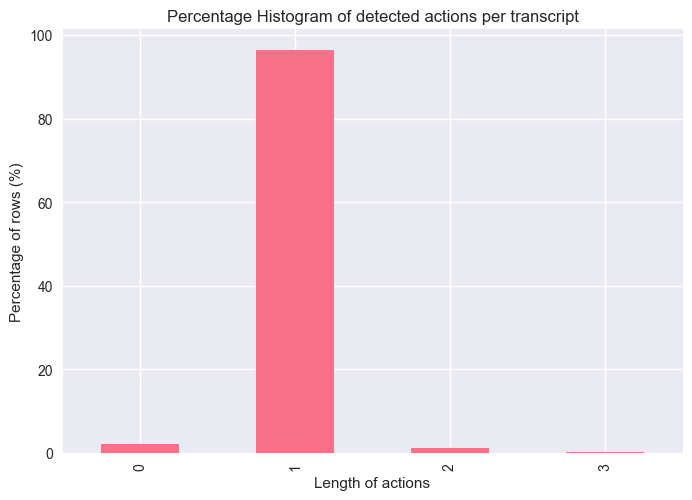

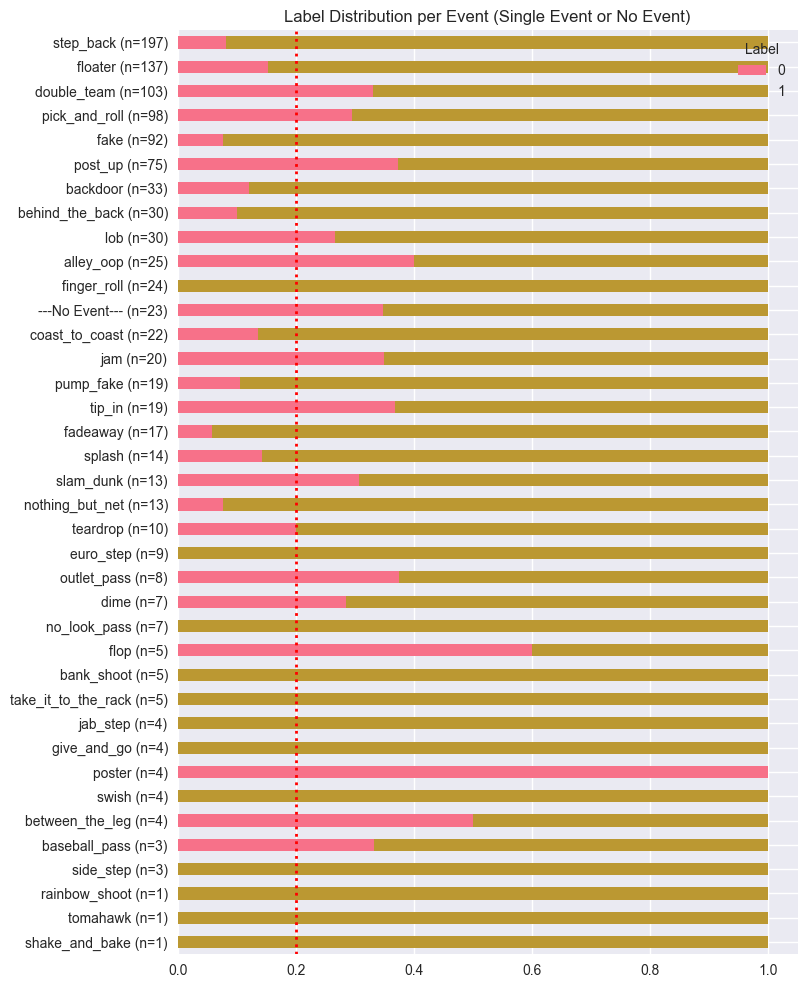

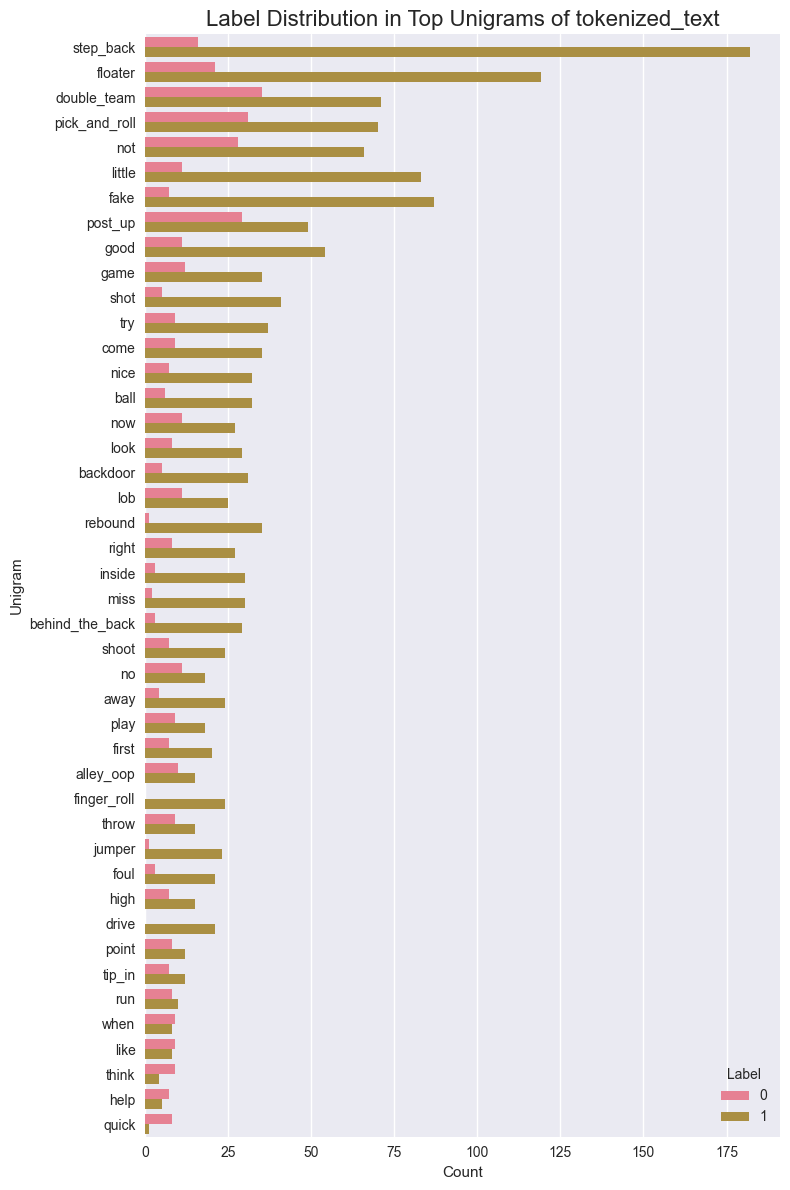

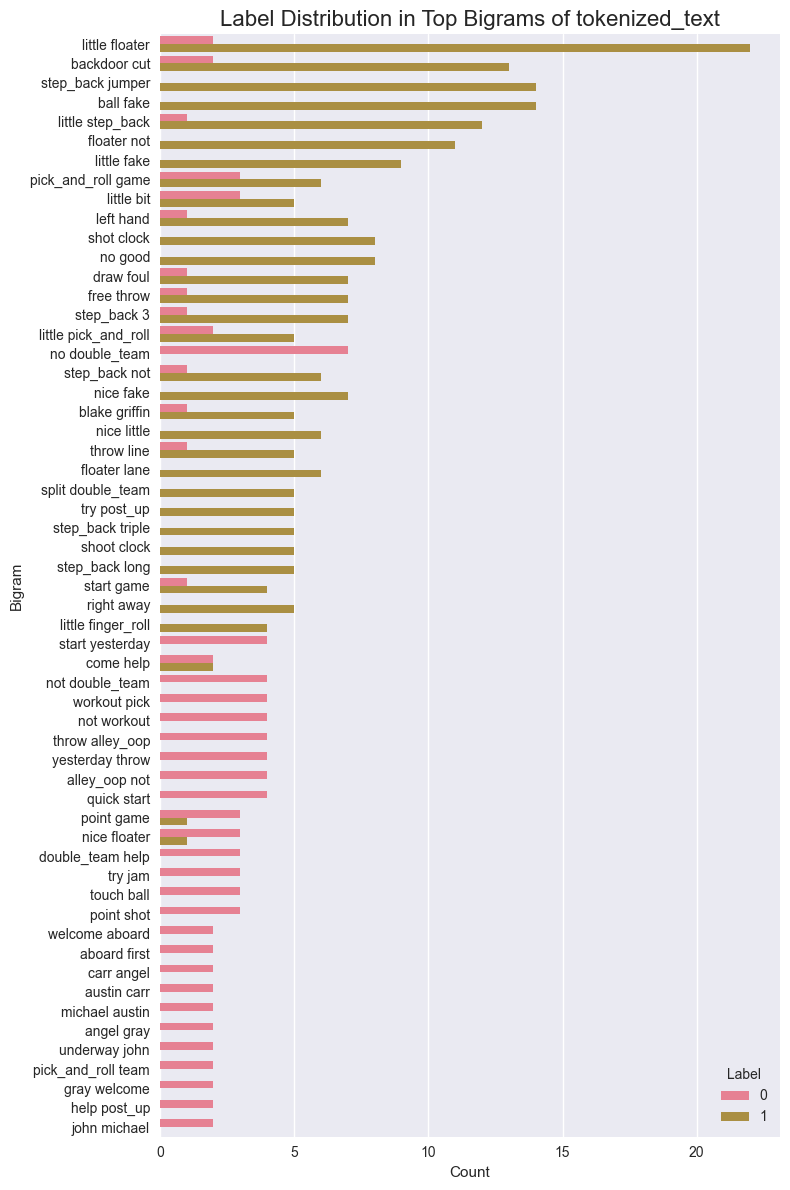

In [ ]:


# 4. Histogram: percentage of rows by len(events)
action_lens = transcripts_df['actions_in_text'].apply(lambda x: len(x) if isinstance(x, list) else 0)
percentages = action_lens.value_counts(normalize=True).sort_index() * 100
percentages.plot(kind='bar')
plt.xlabel('Length of actions')
plt.ylabel('Percentage of rows (%)')
plt.title('Percentage Histogram of detected actions per transcript')
plt.show()

# 1.2 Label distribution per event (single event rows, including empty list/no event)
mask_single_or_empty = transcripts_df['actions_in_text'].apply(lambda x: isinstance(x, list) and (len(x) == 1 or len(x) == 0))
single_events = transcripts_df[mask_single_or_empty].copy()
single_events['actions_in_text'] = single_events['actions_in_text'].apply(lambda x: x[0] if len(x) == 1 else '---No Action---')
counts = single_events['actions_in_text'].value_counts()
labels = single_events.groupby('actions_in_text')['Label'].value_counts(normalize=True).unstack().loc[counts.index]
labels.index = [f"{e} (n={counts[e]})" for e in labels.index]
ax = labels.iloc[::-1].plot.barh(
    stacked=True, 
    title='Label Distribution per Action (Single Action or No Action)', 
    figsize=(8, 12)
)
ax.axvline(0.2, color='red', linestyle='dotted', linewidth=2)
ax.legend(title='Label')
plt.show()


plot_label_distribution_for_ngrams('tokenized_text')





## Actions-Events Analysis

In [35]:
def display_colored_action_event_table(action_event_counters, avg_event_lengths):
    event_cols = [f'event_#{i+1}' for i in range(5)]
    action_event_table = []

    all_events = set()
    for counter in action_event_counters.values():
        all_events.update(counter.keys())
    event_colors = {event: color for event, color in zip(all_events, sns.color_palette("tab20", len(all_events)))}

    # --- Coloring: function for HTML coloring of events ---
    def color_event(event):
        if event is None:
            return ""
        name, count = event
        color = matplotlib.colors.rgb2hex(event_colors.get(name, (0.5, 0.5, 0.5)))
        # Use a heatmap color for the count (normalize count to [0,1])
        max_count = max([c for counter in action_event_counters.values() for c in counter.values()] or [1])
        norm = plt.Normalize(0, max_count)
        cmap = plt.get_cmap("YlOrRd")
        count_color = matplotlib.colors.rgb2hex(cmap(norm(count)))
        return f'<span style="color:{color}; font-weight:bold">{name}</span> <span style="color:{count_color}">({count})</span>'

    action_event_table = []
    for action, counter in action_event_counters.items():
        top_events = counter.most_common(5)
        top_events += [None] * (5 - len(top_events))
        row = {'action': action}
        for i, event_tuple in enumerate(top_events):
            row[event_cols[i]] = event_tuple
        row['num_events'] = sum(counter.values())
        row['avg_#_events'] = avg_event_lengths.get(action, float('nan'))
        action_event_table.append(row)

    action_event_df = pd.DataFrame(action_event_table)
    action_event_df = action_event_df.sort_values('num_events', ascending=False)

    # Display with colored HTML
    def style_row(row):
        styled = []
        for col in action_event_df.columns:
            if col.startswith("event_#"):
                styled.append(color_event(row[col]))
            else:
                styled.append(row[col])
        return styled

    styled_rows = [style_row(row) for _, row in action_event_df.iterrows()]
    header = action_event_df.columns.tolist()
    html = "<table><thead><tr>" + "".join([f"<th>{h}</th>" for h in header]) + "</tr></thead><tbody>"
    for row in styled_rows:
        html += "<tr>" + "".join([f"<td>{cell}</td>" for cell in row]) + "</tr>"
    html += "</tbody></table>"
    display(HTML(html))


mask_0_or_1 = transcripts_df['actions_in_text'].apply(lambda x: isinstance(x, list) and (len(x) <= 1))
filtered = transcripts_df[mask_0_or_1].copy()

filtered['action_for_group'] = filtered['actions_in_text'].apply(lambda x: x[0] if len(x) == 1 else '[]')
action_events = filtered.groupby('action_for_group')['events'].sum()
action_event_counters = {action: Counter(events) for action, events in action_events.items()}

# Calculate average event length for each action
avg_event_lengths = {}
for action, events in filtered.groupby('action_for_group')['events']:
    if len(events) > 0:
        # events is a Series of lists, so flatten and get average length per list
        event_lists = events.tolist()
        avg_len = np.mean([len(ev) for ev in event_lists if isinstance(ev, list)])
        avg_event_lengths[action] = round(avg_len, 2)
    else:
        avg_event_lengths[action] = float('nan')


In [36]:
display_colored_action_event_table(action_event_counters, avg_event_lengths)

action,event_#1,event_#2,event_#3,event_#4,event_#5,num_events,avg_#_events
floater,Missed Shot (68),Rebound (59),2-pointer (52),Assist (21),Foul (9),224,1.64
step_back,Missed Shot (84),2-pointer (48),3-pointer (16),Rebound (15),None (8),197,1.0
double_team,Missed Shot (38),Rebound (27),Assist (26),2-pointer (23),Turnover (21),175,1.7
pick_and_roll,Missed Shot (32),Rebound (27),Assist (21),2-pointer (18),Foul (10),146,1.49
post_up,Missed Shot (24),2-pointer (21),Rebound (19),Assist (15),Foul (10),121,1.61
fake,2-pointer (29),Missed Shot (24),3-pointer (9),Foul (8),None (7),92,1.0
finger_roll,Missed Shot (10),2-pointer (10),Rebound (8),Assist (6),Turnover (3),42,1.75
tip_in,Missed Shot (14),Rebound (12),Jump Ball (5),2-pointer (4),Foul (1),40,2.11
coast_to_coast,Rebound (9),Missed Shot (8),2-pointer (6),Steal (5),Turnover (4),37,1.68
backdoor,2-pointer (9),Missed Shot (9),Turnover (3),Dunk (3),Rebound (3),35,1.06


# Validator analysis

Compare rates of negation tokens by class (no, not, never, without, miss, misses, blocked).

Compare temporal markers by class (after, before, earlier, previous, then, immediately).

In [38]:
temporal_candidates = {
    # basic temporal connectives
    "after", "before", "until", "till", "since", "when", "while", "once", "then", "later", "earlier",
    "eventually", "soon", "previously", "recently", "now",
    # specific time references
    "today", "tomorrow", "yesterday", "tonight", "morning", "afternoon", "evening",
    "day", "week", "month", "year", "season", "period", "half", "quarter",
    # sequence/order terms
    "final", "first", "second", "third", "last", "next"
}

# Broad negation vocabulary
negation_candidates = {
    "no", "not", "n't", "never", "cannot", "can't", "nobody", "none", "nothing", "nowhere",
    "neither", "nor", "without", "minus"
}

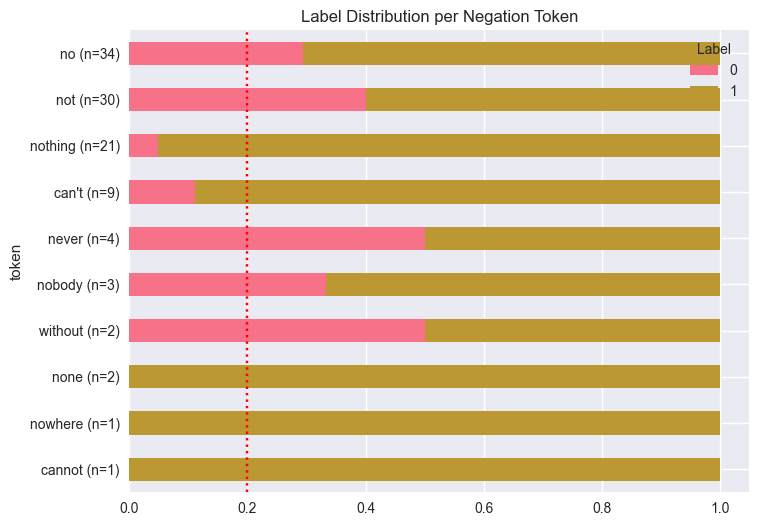

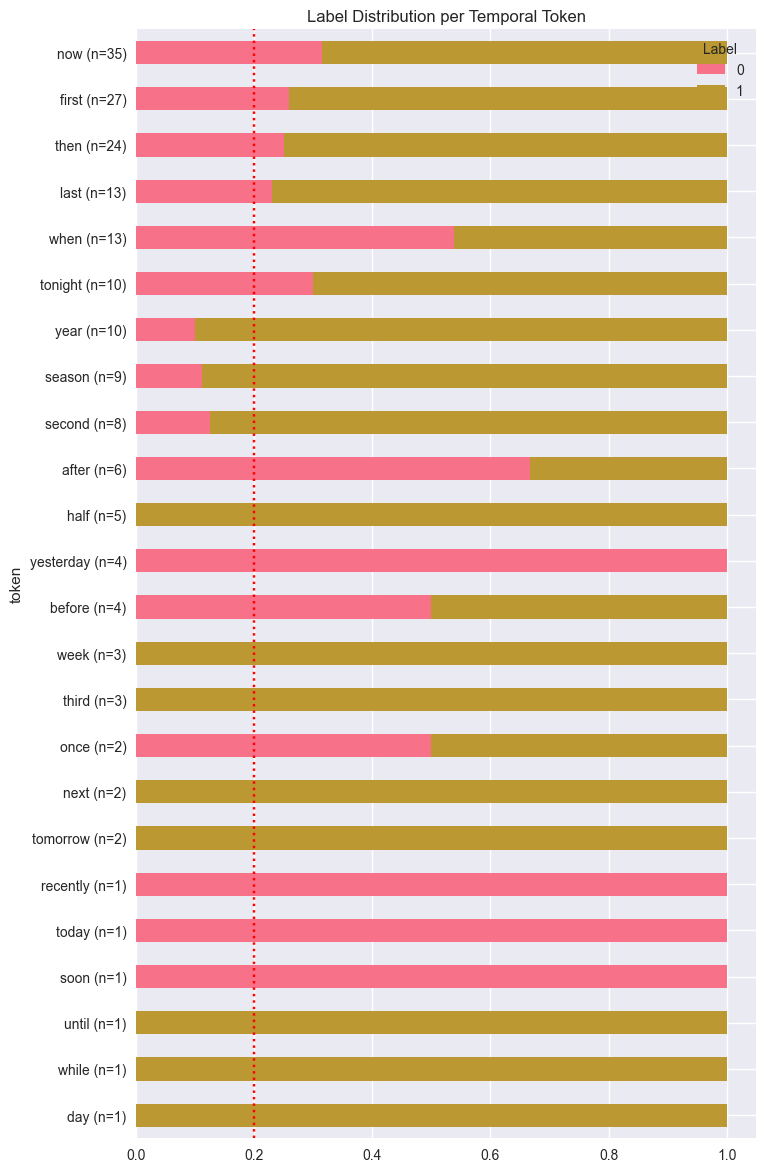

In [39]:
def plot_label_distribution_per_token(words_list, words_type):
    """
    Plots the label distribution per token for a given list of words.
    
    Args:
        words_list (iterable): List or set of words/tokens to check in the text.
        words_type (str): Description of the type of words (used in the plot title).
    """
    label_df = pd.DataFrame([
        [
            token,
            transcripts_df['Text'].str.contains(rf'\b{token}\b', case=False, na=False).sum(),
            *transcripts_df[transcripts_df['Text'].str.contains(rf'\b{token}\b', case=False, na=False)]['Label'].value_counts(normalize=True).reindex([0,1], fill_value=0)
        ]
        for token in words_list
        if transcripts_df['Text'].str.contains(rf'\b{token}\b', case=False, na=False).sum() > 0
    ], columns=['token', '# rows', 0, 1]).set_index('token').sort_values('# rows')

    ax = label_df[[0,1]].plot.barh(
        stacked=True, 
        figsize=(8, max(4, len(label_df)*0.6)), 
        title=f'Label Distribution per {words_type.title()} Token'
    )
    ax.legend(title='Label')
    ax.set_yticklabels([f"{token} (n={count})" for token, count in zip(label_df.index, label_df['# rows'])])
    # Add vertical dotted red line at 0.2
    ax.axvline(0.2, color='red', linestyle='dotted')
    plt.show()

# Example usage for negation tokens:
plot_label_distribution_per_token(negation_candidates, "negation")
plot_label_distribution_per_token(temporal_candidates, "temporal")